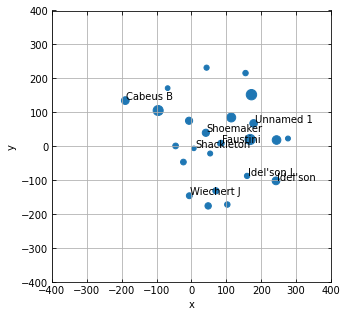

In [267]:
import numpy as np
import pandas as pd
import rasterio as rio
import cannon2020 as model
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': (8, 8),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
})

# Constants
f24 = False
pct_area = 1.30e4
hop_efficiency = 0.054  # From modified Kloos model with Hayne area - Cannon 2020
timesteps = np.arange(425)[::-1] * 0.01  # Gyr, each step is 10 Myr

# Read in Cannon 2020 crater list
fcraters = '~/projects/essi21/data/cannon2020_crater_ages.csv'
cols = ('name', 'lat', 'lon', 'diam', 'age', 'age_low', 'age_upp')
df = pd.read_csv(fcraters, names=cols, header=0)
df['x'], df['y'] = model.latlon2xy(df.lat, df.lon)
df.head()

# Show crater locations
fig, ax = plt.subplots(figsize=(5, 5))
df.plot('x', 'y', s='diam', kind='scatter', ax=ax)
for i, row in df.sort_values('lat')[::3].iterrows():
    ax.annotate(row['name'], (row.x, row.y), xytext=(1, 1), textcoords='offset points')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
plt.grid()
plt.show()

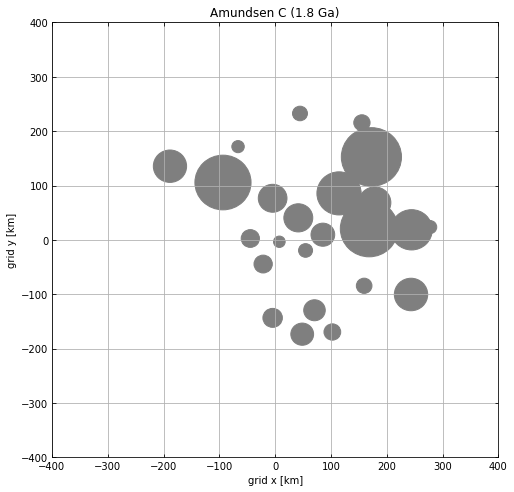

In [276]:
# Make coord indices (this is simple with 1km/pix grids)
# We will probabalistically round the crater to its nearest grid cell
df['xround'] = [model.probabalistic_round(x) for x in df.x]
df['yround'] = [model.probabalistic_round(y) for y in df.y]

# Make coordinate axes centered on each pixel
xarr = np.arange(-400, 401) + 0.5
yarr = np.arange(-400, 401) + 0.5

fig, ax = plt.subplots(figsize=(8, 8))
ax.grid()
ax.set_xlabel('grid x [km]')
ax.set_ylabel('grid y [km]')
ax.set_xlim(-400, 400)
ax.set_ylim(-400, 400)
sdf = df.sort_values('age', ascending=False).reset_index()
for i, row in sdf.iterrows():
    ax.set_title(f"{row['name']} ({row.age} Ga)")
    x = row.xround + 0.5
    y = row.yround + 0.5
    rad = row.diam / 2

    # Draw crater and ejecta zone
    ejecta = plt.Circle((x, y), rad*4, linewidth=4, color='tab:orange', alpha=0.2)
    ax.add_patch(ejecta)
    crater = plt.Circle((x, y), rad, color='tab:green')
    ax.add_patch(crater)


    # Save frame
    f = f'../figs/impact_sequence_gif_frames/frame{i}.png'
    fig.savefig(f, bbox_inches='tight')

    # Remove ejecta and make crater different color
    ax.patches = ax.patches[:-2]
    crater = plt.Circle((x, y), rad, color='tab:gray')
    ax.add_patch(crater)

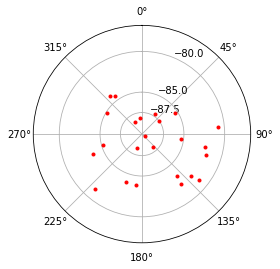

In [223]:
ax = plt.subplot(111, polar=True)
ax.plot(df.lon-90, df.lat, color='r', ls='none', marker='.')
ax.set_rmax(deg_from_pole-90)
ax.set_rticks([-87.5, -85, -80])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

In [24]:
spole_stereo_wkt = """PROJCS["Moon_South_Pole_Stereographic",
                        GEOGCS["Moon 2000",
                            DATUM["D_Moon_2000",
                                SPHEROID["Moon_2000_IAU_IAG",1737400.0,0.0]],
                            PRIMEM["Greenwich",0],
                            UNIT["Decimal_Degree",0.0174532925199433]],
                        PROJECTION["Stereographic"],
                        PARAMETER["False_Easting",0],
                        PARAMETER["False_Northing",0],
                        PARAMETER["Central_Meridian",0],
                        PARAMETER["Scale_Factor",1],
                        PARAMETER["Latitude_Of_Origin",-90],
                        UNIT["Meter",1]]"""

In [21]:
grid_xsize = grid_ysize = 800  # [pix]
xres = yres = 1000  # [m/pix]

transform = rio.Affine(xres, 0, -grid_xsize*xres, 0, -yres, grid_ysize*yres)
crs = rio.crs.CRS.from_wkt(spole_stereo_wkt)

xarr = np.arange(grid_xsize)
yarr = np.arange(grid_ysize)
grd_x, grd_y = np.meshgrid(xarr, yarr, indexing='ij')


In [31]:
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
crs_spole_m = rio.crs.CRS.from_wkt(spole_stereo_wkt)
crs_spole_stereo_deg = rio.crs.CRS.from_wkt(spole_stereo_deg_wkt)
with rio.Env():

    # As source: a 512 x 512 raster centered on 0 degrees E and 0
    # degrees N, each pixel covering 15".
    rows, cols = src_shape = (512, 512)
    d = 1.0/240 # decimal degrees per pixel
    # The following is equivalent to
    # A(d, 0, -cols*d/2, 0, -d, rows*d/2).
    src_transform = A.translation(-cols*d/2, rows*d/2) * A.scale(d, -d)
    src_crs = crs_spole_m
    source = np.ones(src_shape, np.uint8)*255

    # Destination: a 1024 x 1024 dataset in Web Mercator (EPSG:3857)
    # with origin at 0.0, 0.0.
    dst_shape = (1024, 1024)
    dst_transform = A.translation(-237481.5, 237536.4) * A.scale(425.0, -425.0)
    dst_crs = crs_spole_deg
    destination = np.zeros(dst_shape, np.uint8)

    reproject(
        source,
        destination,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)


In [3]:
# make ejecta matrix
R_MOON = 1737  # km
def get_transient_crater_rad(rad, rsc=9.5):
    """Return apparant transient crater radius given radius of final crater (eqn. 9, Xie 2020)."""
    if rad < rsc:
        # Simple crater
        return 0.7 * rad
    # Complex crater
    return 0.7 * rsc**0.15 * rad**0.85

def ejecta_thickness(dist, rad_at):
    """Return ejecta thickness at dist [m] from crater with apparant transient crater radius rad_at (eqn. 3, Xie 2020)"""
    return 0.068 * rad_at * (dist / rad_at) ** -3

def gc_dist(lon1, lat1, lon2, lat2, rp=R_MOON):
    """
    Calculate the great circle distance between two points using the Haversine formula.

    All args must be of equal length, lon and lat in decimal degrees.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return rp * 2 * np.arcsin(np.sqrt(a))

df['rad'] = df['diam'] / 2
df['rad_at'] = df['rad'].apply(get_transient_crater_rad)
df.tail()

,name,lat,lon,diam,age,age_low,age_upp,rad,rad_at
19,Unnamed 3,-83.9,338.3,22.3,3.40,0.50,0.10,11.15,7.619741
20,Wiechert U,-83.4,149.0,30.0,3.40,0.70,0.10,15.00,9.804696
21,Wiechert J,-85.2,182.4,34.9,3.20,0.10,0.30,17.45,11.150201
22,Shackleton,-89.7,129.8,20.9,3.15,0.08,0.05,10.45,7.211165
23,Amundsen C,-80.8,85.2,24.2,1.80,0.20,0.20,12.10,8.168158


In [71]:
f = '/home/cjtu/projects/essi21/data/spole.tif'
arr = np.arange(grid_xsize*grid_ysize).reshape((grid_xsize, grid_ysize))
arr = np.sin(np.rad2deg(grd_x))

rows = cols = 800  # [pix]
res = 0.0174532925199433  # [deg/pix]  75 deg to pole
transform = rio.Affine(xres, 0, -cols*res/2, 0, -yres, rows*res/2)
crs = rio.crs.CRS.from_wkt(spole_stereo_deg_wkt)
profile = {
    'driver': 'GTiff',
    'height': arr.shape[0],
    'width': arr.shape[1],
    'count': 1,
    'dtype': arr.dtype,
    'crs': crs_spole_stereo_deg,
    'transform': transform
}
with rio.open(f, 'w', **profile) as dst:
    dst.write(arr, 1)


<bound method TransformMethodsMixin.index of <open DatasetReader name='/home/cjtu/projects/essi21/data/spole.tif' mode='r'>>
0 0
0 0


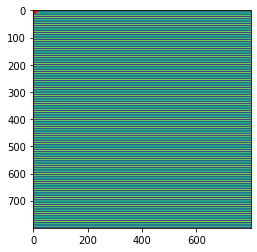

In [87]:
lat = -89.9999
lon = 50
with rio.open(f) as src:
    rows, cols = rio.transform.rowcol(src.transform, lon, lat)
    y, x = src.index(lon, lat)
    print(src.index)

print(rows, cols)
print(x, y)
fig, ax = plt.subplots()
ax.imshow(arr)
ax.scatter(x, y, color='r')

In [90]:
# Make grid centered on S pole
minlat = -80
size = 401  # odd
def polar_grid_360(deg_from_pole, size=401, pole='s'):
    """Returns grid centered on pole to lat 90 - deg_from_pole."""
    sign = 1 if pole == 'n' else -1
    minlat = sign * (90 - deg_from_pole)
    lon_arr = np.linspace(0, 360, size)
    # Center lat on pole
    lat_arr = np.linspace(minlat, sign*90, size//2 + 1)
    lat_arr = np.append(lat_arr, lat_arr[:-1][::-1])
    lon_grid, lat_grid = np.meshgrid(lon_arr, lat_arr)
    return lon_grid, lat_grid

xarr = yarr = np.arange(400)
grd_x, grd_y = np.meshgrid(xarr, yarr, indexing='ij')


In [190]:
def pol2cart(r, theta):
    """Return polar coords in cartesian (x, y)."""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def cart2pol(x, y):
    """Return cartesian coords in polar (r, theta)."""
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return (r, theta)

def latlon2xy(lat, lon, rp=R_MOON):
    """Return (x, y) from pole in units of rp from (lat, lon) [degrees]."""
    theta, azimuth = np.deg2rad(lat), np.deg2rad(lon)
    y = r * np.cos(lat) * np.cos(lon)
    x = r * np.cos(lat) * np.sin(lon)
    return x, y

deg_from_pole = 90 - 76.80885
r = np.linspace(0, deg_from_pole, 400)
theta = np.linspace(0, 2*np.pi, 400)
r_grd, theta_grd = np.meshgrid(r, theta)
x, y = pol2cart(r_grd, theta_grd)

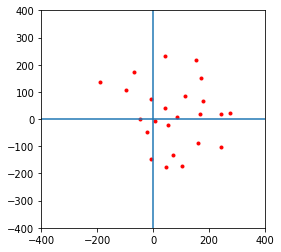

In [193]:
R_MOON = 1737
df2 = df
def latlon2xy(lat, lon, r=R_MOON):
    """Return """
    y, x, _ = sph2cart(df2.lat.values, df2.lon.values, R_MOON)
    return (x, y)

def nearest2D(x, y, xarr, yarr):
    """Find index of closest value in arr to val"""
    xgrd, ygrd = np.meshgrid(xarr, yarr, indexing='ij')
    return np.sqrt((xgrd - x)**2 + (ygrd - y)**2).argmin()



yind, xinds, _ = sph2cart(df2.lat.values, df2.lon.values, R_MOON)
plt.figure(figsize=(4, 4))
plt.plot(y, x, 'r.')
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.axhline(0)
plt.axvline(0)
plt.show()